In [1]:
import sys
sys.path.append('../Modules')
import numpy as np
import pandas as pd

import galsim
from coord import radians

import Image_Fits_Stats
#import Visual_analysis

from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LogNorm
import pywt
from scipy.stats import norm
import math

#Galsim arguments
target_size=64
galaxy_type='real'
psf_type='real'

test_galaxy_index=0

cat = galsim.COSMOSCatalog(sample='23.5')
#Pixel scale in arcsec (the same for all the galaxies)
_,_,_,pixel_scale,_=cat.getRealParams(0)

In [149]:
#Obtain galsim.GSObject for a given galaxy 
#with noise,ellipticity and rotation angle
def get_galaxy(index):
    #Making galaxy
    gal=cat.makeGalaxy(index,gal_type=galaxy_type)
    
    #Get the PSF object
    psf = gal.original_psf
    #Perform convolution with PSF to get the original HST image
    gal=galsim.Convolve(gal, psf)
    
    #Ellipticity
    COSMOS_ellipticity=cat.getParametricRecord(index)['sersicfit'][3]
    
    #Angle
    COSMOS_angle=cat.getParametricRecord(index)['sersicfit'][-1]

    #Noise
    _,_,_,_,COSMOS_noise_variance=cat.getRealParams(index)
    COSMOS_noise=np.sqrt(COSMOS_noise_variance)
    
    return gal,COSMOS_noise,COSMOS_ellipticity,COSMOS_angle

def get_rotated_gal(gal,phi):
        
    # gal.rotate turns anticlockwise, therefore we need to pass -angle
    rot_phi=galsim.Angle(-phi*radians)
    
    rotated_gal=gal.rotate(rot_phi)
    
    return rotated_gal

def get_fit_image(image,fit,profile_type='Sersic'):
    x = np.linspace(0, image.shape[1], image.shape[1])
    y = np.linspace(0, image.shape[0], image.shape[0])
    X, Y = np.meshgrid(x, y)
    # We need to ravel the meshgrids of X, Y points to a pair of 1-D arrays.
    xdata = np.vstack((X.ravel(), Y.ravel()))
    
    if profile_type=='Sersic':
        return Image_Fits_Stats.Sersic_profile(xdata,*fit).reshape(image.shape)
    elif profile_type=='Chameleon_Sersic':
        return Image_Fits_Stats.Chameleon_Sersic(xdata,*fit).reshape(image.shape)
    elif profile_type=='Chameleon':
        return Image_Fits_Stats.Chameleon_profile(xdata,*fit).reshape(image.shape)
    elif profile_type=='Double_Sersic':
        return Image_Fits_Stats.Double_Sersic(xdata,*fit).reshape(image.shape)

Plan for preprocessing:
* Using COSMOS Sersic_phi rotate original image **O** to get the rotated image **R** such that major ellipsis axis is horisontal. Fit galaxy with Sersic profile to extract **ellipticity** and **angle**
* Using **ellipticity** and **angle** extract Radial profile and **R_cut** from it.
* Downscale the image like **R_cut**->64.
* Extract the noise from the background region
* Carry out Chameleon+Sersic fits and cut the image


# 1. Fit the rotated image

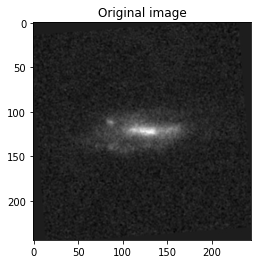

In [151]:
gal,COSMOS_noise,COSMOS_ellipticity,COSMOS_angle=get_galaxy(test_galaxy_index)
rotated_gal=get_rotated_gal(gal,COSMOS_angle)
rotated_image=rotated_gal.drawImage(use_true_center=True, method='auto').array

profile_type='Sersic'
fit,_=Image_Fits_Stats.fit_image(rotated_image,profile_type=profile_type,noise_std=COSMOS_noise,exposure_time=2028)
ellipticity,x0,y0,angle=fit[-4:]

plt.imshow(rotated_image,cmap='gray')
plt.title("Original image")
plt.show()

# 2. Radial profile and R_cut

In [152]:
def get_R_cut(Radial_profile_threshold,image,ellipticity=1,x0=None,y0=None,angle=0):
    
    #Getting border of galaxy from radial profile
    Radial_profile=Image_Fits_Stats.Radial_profile(image,ellipticity,x0,y0,angle)
    
    #Normalise Radial profile to [0,1] values
    Radial_profile=Radial_profile-Radial_profile[-1]
    Radial_profile/=Radial_profile.max()

    #Get R_cut from first value below the border
    R_cut=np.where((Radial_profile<=Radial_profile_threshold))[0][0]
    return R_cut

def get_Background_mask(image_shape,R_cut,ellipticity):
    Background_mask=np.ones(image_shape,dtype='bool')
    
    #transform the images to make borders more observable
    x0=image_shape[1]/2
    y0=image_shape[0]/2
    for y in range(image_shape[0]):
        for x in range(image_shape[1]):
            #Radius in elliptic coordinates 
            #(we that 'x' is major axis of ellipsis)
            R=np.sqrt(np.power((x-x0),2)+np.power((y-y0),2)/np.power(ellipticity,2))
            if(R<=R_cut):
                Background_mask[y,x]=False
    
    return Background_mask

In [160]:
Radial_profile_threshold=1/100
original_image=gal.drawImage(use_true_center=True, method='auto').array


original_R_cut=get_R_cut(Radial_profile_threshold,original_image,
                         ellipticity=ellipticity,
                         angle=COSMOS_angle)

#Size estimation is much more accurate on rotated image
#Since the ellipsis axis are perfectly aligned (major - x, minor - y)
rotated_R_cut=get_R_cut(Radial_profile_threshold,rotated_image,
                         ellipticity=ellipticity,
                         angle=angle)
    
print('Image size',rotated_image.shape)
print('Size extracted from the original image',(round(2*original_R_cut*ellipticity),2*original_R_cut))
print('Size extracted from the rotated image',(round(2*rotated_R_cut*ellipticity),2*rotated_R_cut))

Image size (244, 244)
Size extracted from the original image (71, 198)
Size extracted from the rotated image (71, 200)


In [156]:
df=pd.read_csv('Test data/Labels_0_50932_old.csv',index_col=0)
print('Size from previous processing',(round(2*df.iloc[test_galaxy_index]['Original_R_cut']*df.iloc[test_galaxy_index]['Sersic_q']),
                                       2*df.iloc[test_galaxy_index]['Original_R_cut']))

Size from previous processing (78, 180.0)


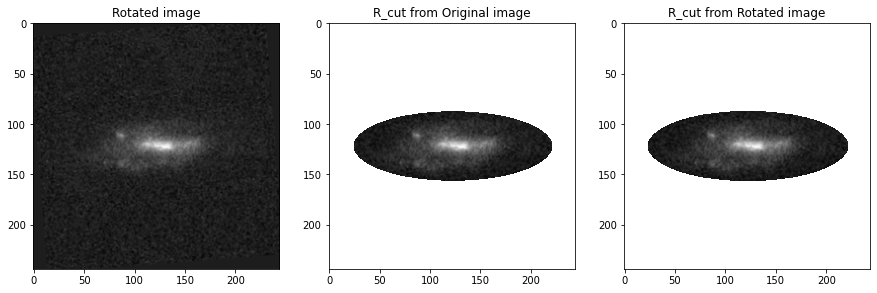

In [157]:
original_Background_mask=get_Background_mask(rotated_image.shape,original_R_cut,ellipticity)
rotated_Background_mask=get_Background_mask(rotated_image.shape,rotated_R_cut,ellipticity)

#Visualise the separation
Galaxy_image_orig=rotated_image.copy()
Galaxy_image_orig[original_Background_mask]=np.nan


Galaxy_image_rot=rotated_image.copy()
Galaxy_image_rot[rotated_Background_mask]=np.nan


f, ax = plt.subplots(1, 3, figsize=(15,10))
ax[0].imshow(rotated_image,cmap='gray')
ax[0].set_title("Rotated image")
ax[1].imshow(Galaxy_image_orig,cmap='gray')
ax[1].set_title("R_cut from Original image")
ax[2].imshow(Galaxy_image_rot,cmap='gray')
ax[2].set_title("R_cut from Rotated image")
plt.show()

In general the rotated image is the final one. So it is sensible to extract properties from it. Moreover, extraction of size from Rotated image is more robust since ellipsis axes are aligned (x-major,y-minor). Therefore we image discretisation should less aggravate the result.

# 3. Downscale the image 

## drawImage options

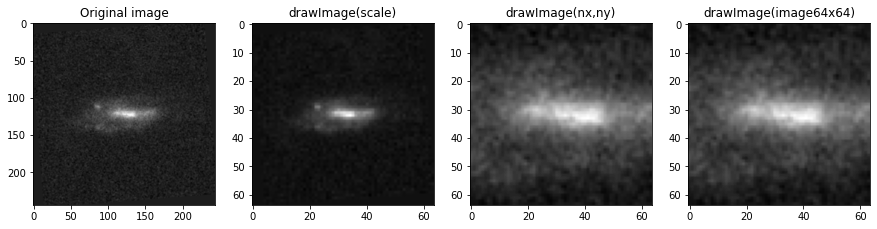

In [163]:
size=np.min(rotated_image.shape)
Scaling_factor=64/size
Galsim_scale=pixel_scale*(size-2)/(target_size-2)
Scaled_image=rotated_gal.drawImage(scale=Galsim_scale,use_true_center=True, method='auto').array

Cropped_image=rotated_gal.drawImage(nx=64,ny=64,use_true_center=True, method='auto').array

im=galsim.Image(64,64)
Prepared_image=rotated_gal.drawImage(image=im,use_true_center=True, method='auto',add_to_image=True).array


f, ax = plt.subplots(1, 4, figsize=(15,10))
ax[0].imshow(rotated_image,cmap='gray')
ax[0].set_title("Original image")
ax[1].imshow(Scaled_image,cmap='gray')
ax[1].set_title("drawImage(scale)")
ax[2].imshow(Cropped_image,cmap='gray')
ax[2].set_title("drawImage(nx,ny)")
ax[3].imshow(Prepared_image,cmap='gray')
ax[3].set_title("drawImage(image64x64)")
plt.show()

**Conclusion** : If we are to change the size of the image, but keep whole galaxy, we need to use the parameter **scale**, instead of **nx**, **ny**, **image** in **gal.drawImage**

## Downscaling

In [164]:
def downscale_galaxy(gal,image_size,galaxy_size,target_size):
    #Our goal is to transform the galaxy such that galaxy_size->target_size
    #However, we only use downscaling, so if initial galaxy_size<target_size
    #we leave the image as it is
    
    if target_size<galaxy_size:
        #We want to downscale image,so galaxy_size->target_size
        
        #The scale may seem strange but Galsim usually works in terms Galsim_size=Image_size-2
        Galsim_scale=pixel_scale*(galaxy_size-2)/(target_size-2)
        
        image_scaled=gal.drawImage(scale=Galsim_scale,use_true_center=True, method='auto').array
        
        #Sanity check because Galsim sometimes do weird stuff
        if image_scaled.shape<(64,64):
            print('Wrong galsim shape, index:',index)
            return False
        
        galaxy_size=target_size
        #If everything is ok return the scaled image 
        #and the result galaxy_size
        return image_scaled,target_size
    
    
    elif target_size<=image_size:
        #Here image_size≥target_size≥galaxy_size
        #We don't want to upscale anything which is needed for  
        #It literally means that no downscaling is needed
        #hence return the original values
        result_image=gal.drawImage(use_true_center=True, method='auto').array
        return result_image,galaxy_size
    
    else:
        #The original image is smaller than the desired one.
        #We don't want to upscale anything or use padding
        #So this galaxy doesn't suit our needs
        print('Original size is less than the target size')
        return False,False

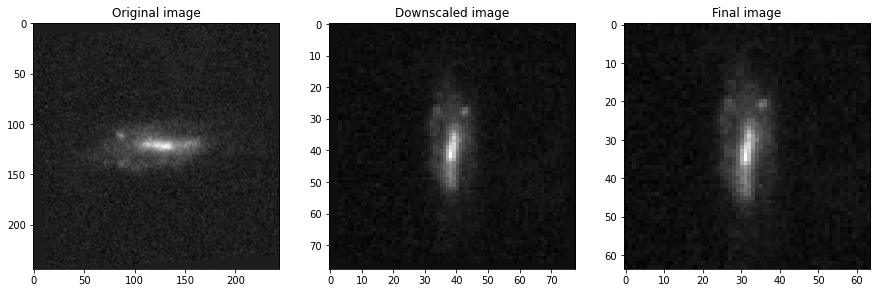

In [169]:
image_size=np.min(rotated_image.shape)
galaxy_size=2*rotated_R_cut
target_size=64

#Obtained image with galaxy_size≤target_size
Scaled_image,galaxy_size=downscale_galaxy(gal,image_size,galaxy_size,target_size)

#R_cut=galaxy_size//2
#Extract properly sized square image,i.e. with target_size
x0=Scaled_image.shape[1]//2
y0=Scaled_image.shape[0]//2
target_radius=target_size//2
Final_image=Scaled_image[y0-target_radius:y0+target_radius,
                         x0-target_radius:x0+target_radius]

f, ax = plt.subplots(1, 3, figsize=(15,10))
ax[0].imshow(rotated_image,cmap='gray')
ax[0].set_title("Original image")
ax[1].imshow(Scaled_image,cmap='gray')
ax[1].set_title("Downscaled image")
ax[2].imshow(Final_image,cmap='gray')
ax[2].set_title("Final image")
plt.show()

In [167]:
previous_images=np.load('Test data/Images_0_50932_old.npy')

Text(0.5, 1.0, 'Previous processing result')

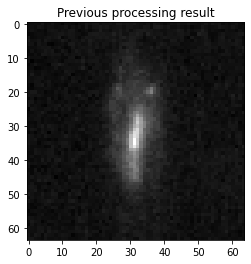

In [168]:
plt.imshow(previous_images[0],cmap='gray')
plt.title('Previous processing result')

It looks better ??????

# 4. Extract noise

# 1. Rotate the original image

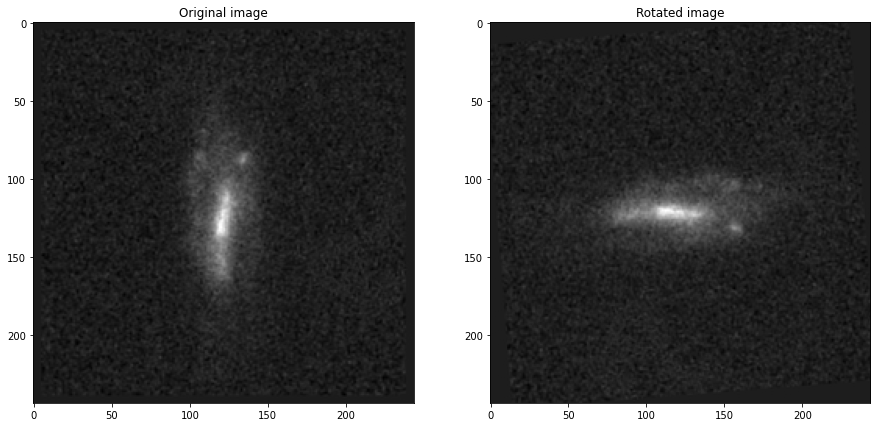

In [40]:
gal,_=get_galaxy(test_galaxy_index)
original_image=gal.drawImage(use_true_center=True, method='auto').array
rotated_gal,q=get_rotated_gal(test_galaxy_index)
rotated_image=rotated_gal.drawImage(use_true_center=True, method='auto').array

f, ax = plt.subplots(1, 2, figsize=(15,10))
ax[0].imshow(original_image,cmap='gray')
ax[0].set_title("Original image")
ax[1].imshow(rotated_image,cmap='gray')
ax[1].set_title("Rotated image")
plt.show()

# 2. Radial profile and R_cut

In [11]:
Radial_profile_threshold=1/200

#Getting border of galaxy from radial profile
Radial_profile=Image_Fits_Stats.Radial_profile(rotated_image,COSMOS_ellipt)


#Normalise Radial profile to [0,1] values
Radial_profile=Radial_profile-Radial_profile[-1]
Radial_profile/=Radial_profile.max()

#Get R_cut from first value below the border
R_cut=np.where((Radial_profile<Radial_profile_threshold))[0]
if len(R_cut)==0:
    R_cut=np.min(rotated_image)/2
else:
    R_cut=R_cut[0]
    
print('Image size',rotated_image.shape)
print('Extracted size',(round(2*R_cut*COSMOS_ellipt),2*R_cut))

Image size (244, 244)
Extracted size (74, 230)


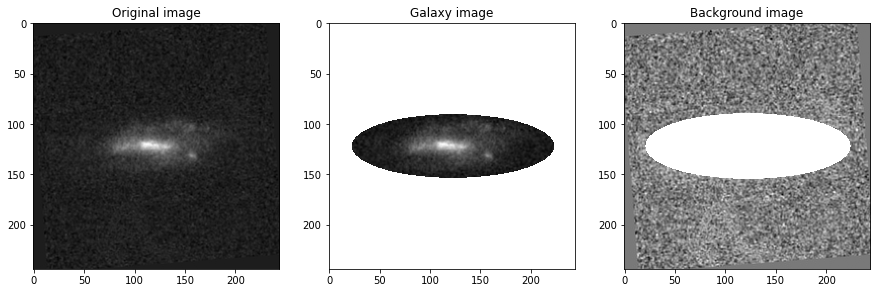

In [68]:
Background_image[11,0]

-0.0001321039

# 3. Image downscaling

## drawImage options

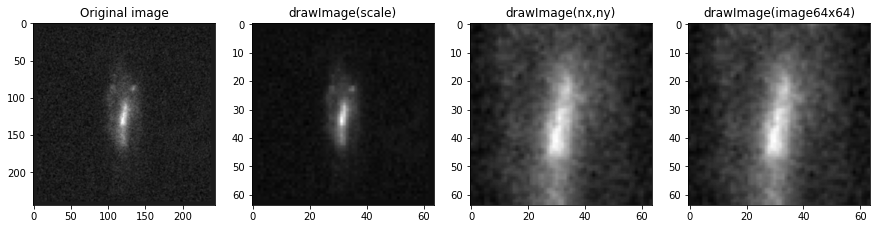

In [44]:
gal,_=get_galaxy(test_galaxy_index)

Original_image=gal.drawImage(use_true_center=True, method='auto').array

size=np.min(Original_image.shape)
Scaling_factor=64/size
Galsim_scale=pixel_scale*(size-2)/(target_size-2)
Scaled_image=gal.drawImage(scale=Galsim_scale,use_true_center=True, method='auto').array

Cropped_image=gal.drawImage(nx=64,ny=64,use_true_center=True, method='auto').array

im=galsim.Image(64,64)
Prepared_image=gal.drawImage(image=im,use_true_center=True, method='auto',add_to_image=True).array


f, ax = plt.subplots(1, 4, figsize=(15,10))
ax[0].imshow(Original_image,cmap='gray')
ax[0].set_title("Original image")
ax[1].imshow(Scaled_image,cmap='gray')
ax[1].set_title("drawImage(scale)")
ax[2].imshow(Cropped_image,cmap='gray')
ax[2].set_title("drawImage(nx,ny)")
ax[3].imshow(Prepared_image,cmap='gray')
ax[3].set_title("drawImage(image64x64)")
plt.show()

## Downscaling

In [45]:
def downscale_galaxy(gal,image_size,galaxy_size,target_size):
    #Our goal is to transform the galaxy such that galaxy_size->target_size
    #However, we only use downscaling, so if initial galaxy_size<target_size
    #we leave the image as it is
    
    if target_size<galaxy_size:
        #We want to downscale image,so galaxy_size->target_size
        
        #The scale may seem strange but Galsim usually works in terms Galsim_size=Image_size-2
        Galsim_scale=pixel_scale*(galaxy_size-2)/(target_size-2)
        
        image_scaled=gal.drawImage(scale=Galsim_scale,use_true_center=True, method='auto').array
        
        #Sanity check because Galsim sometimes do weird stuff
        if image_scaled.shape<(64,64):
            print('Wrong galsim shape, index:',index)
            return False
        
        galaxy_size=target_size
        #If everything is ok return the scaled image 
        #and the result galaxy_size
        return image_scaled,target_size
    
    
    elif target_size<=image_size:
        #Here image_size≥target_size≥galaxy_size
        #We don't want to upscale anything which is needed for  
        #It literally means that no downscaling is needed
        #hence return the original values
        result_image=gal.drawImage(use_true_center=True, method='auto').array
        return result_image,galaxy_size
    
    else:
        #The original image is smaller than the desired one.
        #We don't want to upscale anything or use padding
        #So this galaxy doesn't suit our needs
        print('Original size is less than the target size')
        return False,False

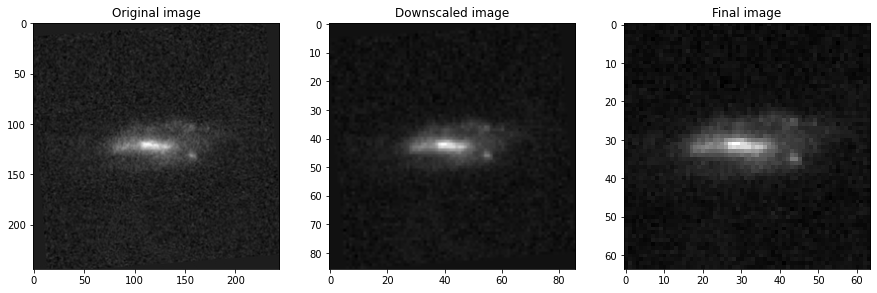

In [49]:
image_size=np.min(rotated_image.shape)
galaxy_size=2*R_cut
target_size=64

#Obtained image with galaxy_size≤target_size
Scaled_image,galaxy_size=downscale_galaxy(rotated_gal,image_size,galaxy_size,target_size)

#R_cut=galaxy_size//2
#Extract properly sized square image,i.e. with target_size
x0=Scaled_image.shape[1]//2
y0=Scaled_image.shape[0]//2
target_radius=target_size//2
Final_image=Scaled_image[y0-target_radius:y0+target_radius,
                         x0-target_radius:x0+target_radius]

f, ax = plt.subplots(1, 3, figsize=(15,10))
ax[0].imshow(rotated_image,cmap='gray')
ax[0].set_title("Original image")
ax[1].imshow(Scaled_image,cmap='gray')
ax[1].set_title("Downscaled image")
ax[2].imshow(Final_image,cmap='gray')
ax[2].set_title("Final image")
plt.show()

# 4. Noise extraction

In [50]:
'''
skimage.restoration.estimate_sigma
[1] D. L. Donoho and I. M. Johnstone. "Ideal spatial adaptation 
by wavelet shrinkage." Biometrika 81.3 (1994): 425-455.
       :DOI:`10.1093/biomet/81.3.425`
'''
def estimate_sigma(array,noise_border_size):

    
    coeffs = pywt.dwtn(array, wavelet='db2')
    detail_coeffs = coeffs['d' * array.ndim]

    # Consider regions with detail coefficients exactly zero to be masked out
    detail_coeffs = detail_coeffs[np.nonzero(detail_coeffs)]

    # 75th quantile of the underlying, symmetric noise distribution
    denom = norm.ppf(0.75)
    return np.median(np.abs(detail_coeffs)) / denom



## recall our division into galaxy and background

In [ ]:
Galaxy_image=Scaled_image.copy()
Background_image=Scaled_image.copy()

#transform the images to make borders more observable
x0=Scaled_image.shape[1]/2
y0=Scaled_image.shape[0]/2
for y in range(Scaled_image.shape[0]):
    for x in range(rotated_image.shape[1]):
        #Radius in elliptic coordinates
        R=np.sqrt(np.power((x-x0),2)+np.power((y-y0),2)/np.power(q,2))
        if(R>R_cut):
            Galaxy_image[y,x]=rotated_image.max()
        else:
            Background_image[y,x]=rotated_image.max()